In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import multiclass
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import sklearn.preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPool1D, GlobalMaxPool1D, Activation, SpatialDropout1D, LSTM, SimpleRNN, GRU
from keras.optimizers import Adam, SGD, RMSprop
from keras import losses, optimizers
from keras import preprocessing
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy

from matplotlib import pyplot as plt

import tensorflow as tf

Izvršićemo klasifikaciju podataka neurnoskim mrežama za 2 kategorije. Učitaćemo podatke i odraditi vektorizaciju, a zatim podeliti na podatke na trening, test i validacione skupove. Isprobavali smo različite vrednosti za parametre modela (units, epochs, batch_size, learning_rate) kao i broj slojeva i za ove vrednosti smo dobili najbolje moguće modele za naše podatke.

Funkcija <i>GetData</i> će nam služiti za učitavanje podataka u zavisnosti od broja kategorija.

In [2]:
def GetData(num_of_categories, categories):
    news = pd.read_csv('data/vesti.csv')
    if num_of_categories == 36:
        X = news['text']
        y = news['category']
    else:
        news = news[news.category.isin(categories)]
        X = news['text']
        y = news['category']
        
    return (X, y)

Funkcija <i>TransformData</i> izršava vektorizaciju nad skupom X i prevodi kategoričke vrednosti skupa y u indikatorske promenljive.

In [3]:
def TransformData(X, y):
    vectorizer = feature_extraction.text.TfidfVectorizer()
    vectorizer.fit(X.values.astype('U'))

    X_transformed = vectorizer.transform(X.values.astype('U'))

    y_transformed = pd.get_dummies(y).values
    
    return (X_transformed, y_transformed)

Funkcija <i>TrainTestValidationSplit</i> deli podatke na trening, validacioni (validation size: 0.2) i test (test size: 0.2) skup sa stratifikacijom po y skupu.

In [4]:
def TrainTestValidationSplit(X, y):
    X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 4)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size = 0.2, stratify = y_train_validation, random_state = 4)
    
    return (X_train, X_validation, X_test, y_train, y_validation, y_test)

Funkcija <i>EvaluateModel</i> će služiti za evaluaciju podataka na test skupu i vizualizaciju dobijenih vrednosti funkcije greške i tačnosti.

In [5]:
def EvaluateModel(model, X_test, y_test, history):
    score = model.evaluate(X_test, y_test)
    print('Test loss: ', score[0])
    print('Test accuracy: ', score[1])
    
    epochs = history.epoch
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12,8))
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.plot(epochs, loss, c='red', label = 'training')
    plt.plot(epochs, validation_loss, c='orange', label='validation')
    plt.legend(loc = 'best')
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs, accuracy, c='red', label = 'training')
    plt.plot(epochs, validation_accuracy, c = 'orange', label = 'validation')
    plt.legend(loc = 'best')
    plt.show()

Funkcija <i>TransformToTensor</i> izvrsava dekompoziciju pomocu TruncatedSVD algoritma i proveravamo variansu kako bismo ocuvali smisao podataka, zatim na kraju pretvaramo transformisane podatke u tenzor kako bismo mogli da pokrenemo modele.

In [6]:
def TransformToTensor(X, n):
    pca = decomposition.TruncatedSVD(n_components=n, random_state=4)
    pca.fit(X)
    print(sum(pca.explained_variance_ratio_))
    X = pca.transform(X)
    return tf.convert_to_tensor(X)

### Klasifikacija za 2 kategorije

Učitavamo podatke za dve kategorije koje imaju najveći broj članaka u skupu.

In [7]:
categories2 = ['SPORTS', 'FOOD & DRINK']
X2, y2 = GetData(2, categories2)
print(X2.shape)
print(y2.shape)

(11091,)
(11091,)


Delimo podatke na trening, test i validacioni skup, a zatim ih transformišemo pomoću funkcije TransformData.

In [8]:
X2_train, X2_validation, X2_test, y2_train, y2_validation, y2_test = TrainTestValidationSplit(X2, y2)

In [9]:
X2_train_transformed, y2_train_transformed = TransformData(X2_train, y2_train)
X2_validation_transformed, y2_validation_transformed = TransformData(X2_validation, y2_validation)
X2_test_transformed, y2_test_transformed = TransformData(X2_test, y2_test)

In [10]:
print(X2_train_transformed.shape)
print(y2_train_transformed.shape)

(7097, 15641)
(7097, 2)


In [11]:
print(X2_validation_transformed.shape)
print(y2_validation_transformed.shape)

(1775, 7592)
(1775, 2)


In [12]:
print(X2_test_transformed.shape)
print(y2_test_transformed.shape)

(2219, 8646)
(2219, 2)


In [13]:
X2_train_transformed = TransformToTensor(X2_train_transformed, 2000)
X2_validation_transformed = TransformToTensor(X2_validation_transformed, 1000)
X2_test_transformed = TransformToTensor(X2_test_transformed, 1000)

0.7579897184112458
0.8280922612225192
0.7653459268269318


Kreiramo modele i zatim prikazujemo rezultate.

In [14]:
model1 = Sequential()
model1.add(Embedding(input_dim = 2000, output_dim = 32, input_length = X2_train_transformed.shape[1]))
model1.add(LSTM(64, dropout = 0.2, recurrent_dropout = 0.2))
model1.add(Dense(2, activation='softmax'))

model1.compile(optimizer = Adam(learning_rate = 0.0001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 88,962
Trainable params: 88,962
Non-trainable params: 0
_________________________________________________________________


In [15]:
history1 = model1.fit(X2_train_transformed, y2_train_transformed, epochs=5, batch_size=32, validation_data=(X2_validation_transformed, y2_validation_transformed))

Epoch 1/5
222/222 [==============================] - 446s 2s/step - loss: 0.6877 - accuracy: 0.5563 - val_loss: 0.6860 - val_accuracy: 0.5600
Epoch 2/5
222/222 [==============================] - 463s 2s/step - loss: 0.6862 - accuracy: 0.5600 - val_loss: 0.6860 - val_accuracy: 0.5600
Epoch 3/5
222/222 [==============================] - 444s 2s/step - loss: 0.6861 - accuracy: 0.5600 - val_loss: 0.6860 - val_accuracy: 0.5600
Epoch 4/5
222/222 [==============================] - 445s 2s/step - loss: 0.6862 - accuracy: 0.5600 - val_loss: 0.6859 - val_accuracy: 0.5600
Epoch 5/5
222/222 [==============================] - 440s 2s/step - loss: 0.6860 - accuracy: 0.5600 - val_loss: 0.6860 - val_accuracy: 0.5600


70/70 [==============================] - 7s 94ms/step - loss: 0.6859 - accuracy: 0.5602
Test loss:  0.6859298348426819
Test accuracy:  0.5601622462272644


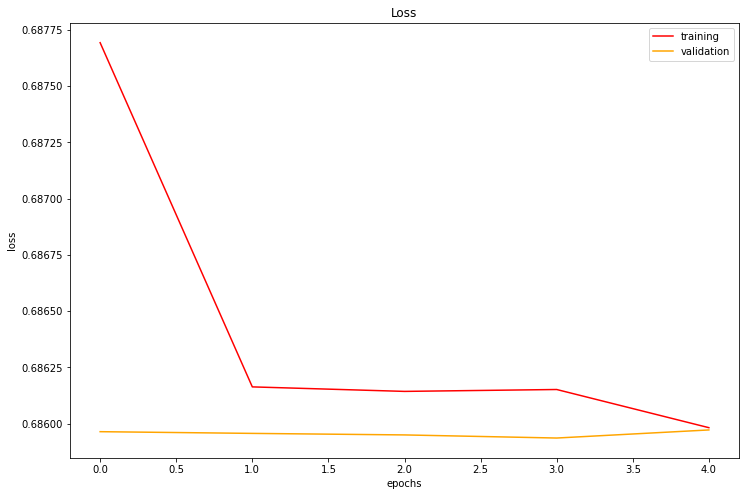

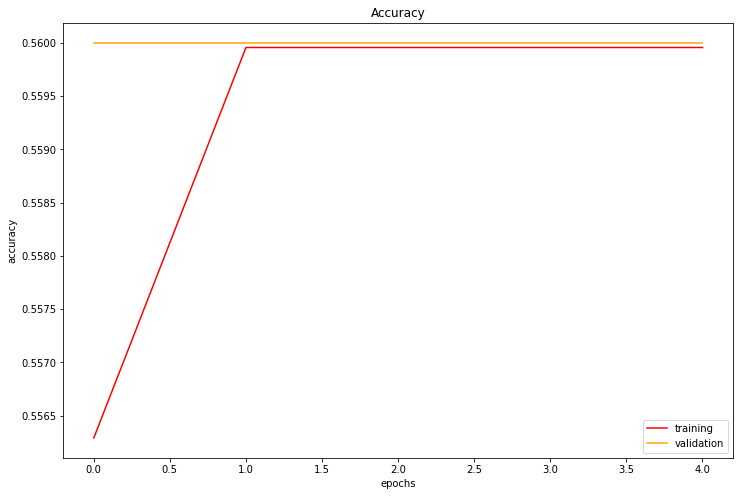

In [16]:
EvaluateModel(model1, X2_test_transformed, y2_test_transformed, history1)

In [17]:
model2 = Sequential()
model2.add(Embedding(input_dim = 2000, output_dim = 32, input_length = X2_train_transformed.shape[1]))
model2.add(GRU(64))
model2.add(Dense(2, activation='softmax'))

model2.compile(optimizer = Adam(learning_rate = 0.0001), loss = CategoricalCrossentropy(), metrics = ['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          64000     
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 82,946
Trainable params: 82,946
Non-trainable params: 0
_________________________________________________________________


In [19]:
history2 = model2.fit(X2_train_transformed, y2_train_transformed, epochs=10, batch_size=32, validation_data=(X2_validation_transformed, y2_validation_transformed))

Epoch 1/10
222/222 [==============================] - 251s 1s/step - loss: 0.6869 - accuracy: 0.5600 - val_loss: 0.6859 - val_accuracy: 0.5600
Epoch 2/10
222/222 [==============================] - 259s 1s/step - loss: 0.6861 - accuracy: 0.5600 - val_loss: 0.6860 - val_accuracy: 0.5600
Epoch 3/10
222/222 [==============================] - 303s 1s/step - loss: 0.6860 - accuracy: 0.5600 - val_loss: 0.6862 - val_accuracy: 0.5600
Epoch 4/10
222/222 [==============================] - 335s 2s/step - loss: 0.6861 - accuracy: 0.5600 - val_loss: 0.6859 - val_accuracy: 0.5600
Epoch 5/10
222/222 [==============================] - 318s 1s/step - loss: 0.6859 - accuracy: 0.5600 - val_loss: 0.6861 - val_accuracy: 0.5600
Epoch 6/10
222/222 [==============================] - 314s 1s/step - loss: 0.6861 - accuracy: 0.5600 - val_loss: 0.6859 - val_accuracy: 0.5600
Epoch 7/10
222/222 [==============================] - 311s 1s/step - loss: 0.6861 - accuracy: 0.5600 - val_loss: 0.6860 - val_accuracy: 0.5600

70/70 [==============================] - 5s 78ms/step - loss: 0.6859 - accuracy: 0.5602
Test loss:  0.6858910322189331
Test accuracy:  0.5601622462272644


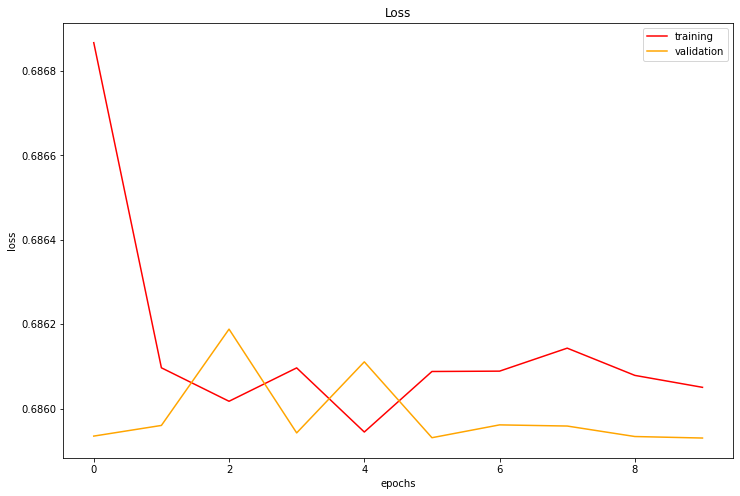

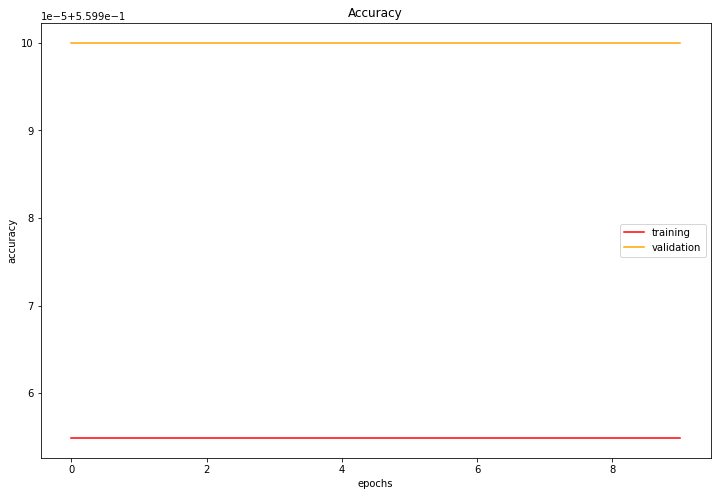

In [20]:
EvaluateModel(model2, X2_test_transformed, y2_test_transformed, history2)